<a href="https://colab.research.google.com/github/shreyaa-1702/Age-gender_detection/blob/main/Age_gender_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Gender: Female
Age: 38-43 years


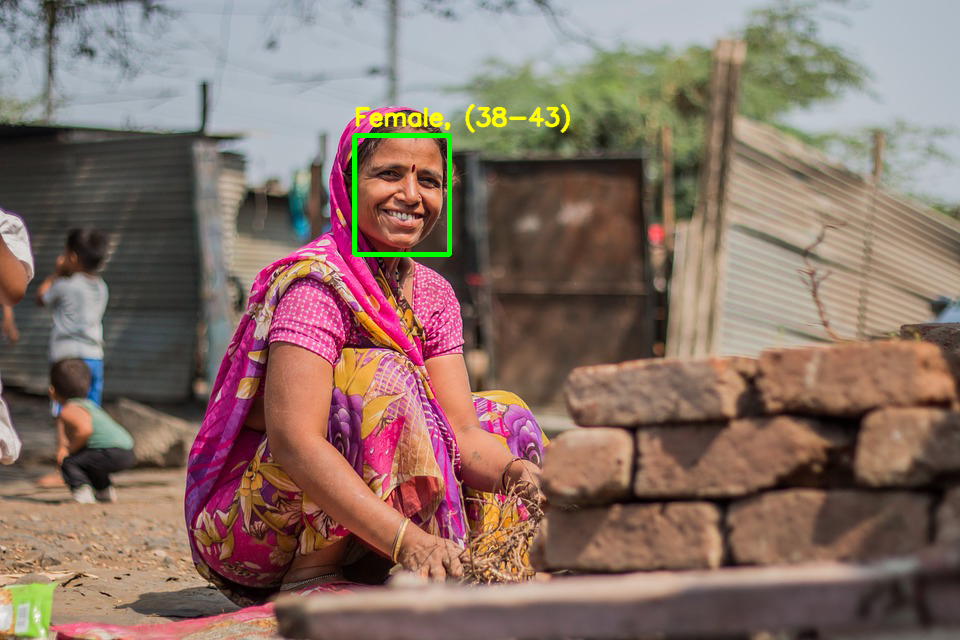

In [15]:
import cv2
import math
import argparse
import pandas as pd
import sys
from google.colab.patches import cv2_imshow  # Import cv2_imshow for Colab

# Check if the script is running in a notebook environment
if 'ipykernel' in sys.modules:
    sys.argv = sys.argv[:1]  # Strip out unwanted arguments
    # Manually set the image path or use 0 for webcam in the notebook
    args = type('', (), {})()  # Create a simple object to hold attributes
    args.image = "/content/woman1.jpg"  # Replace with your image path or use 0 for webcam
else:
    # If not in notebook, use argparse as usual for command-line execution
    parser = argparse.ArgumentParser()
    parser.add_argument('--image')
    args = parser.parse_args()

def highlightFace(net, frame, conf_threshold=0.7):
    frameOpencvDnn = frame.copy()
    frameHeight = frameOpencvDnn.shape[0]
    frameWidth = frameOpencvDnn.shape[1]
    blob = cv2.dnn.blobFromImage(frameOpencvDnn, 1.0, (300, 300), [104, 117, 123], True, False)

    net.setInput(blob)
    detections = net.forward()
    faceBoxes = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            faceBoxes.append([x1, y1, x2, y2])
            cv2.rectangle(frameOpencvDnn, (x1, y1), (x2, y2), (0, 255, 0), int(round(frameHeight / 150)), 8)
    return frameOpencvDnn, faceBoxes


faceProto = "opencv_face_detector.pbtxt"
faceModel = "opencv_face_detector_uint8.pb"
ageProto = "age_deploy.prototxt"
ageModel = "age_net.caffemodel"
genderProto = "gender_deploy.prototxt"
genderModel = "gender_net.caffemodel"

MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)
ageList = ['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']
genderList = ['Male', 'Female']

faceNet = cv2.dnn.readNet(faceModel, faceProto)
ageNet = cv2.dnn.readNet(ageModel, ageProto)
genderNet = cv2.dnn.readNet(genderModel, genderProto)

# Open the video stream or use a specific image
video = cv2.VideoCapture(args.image if args.image else 0)
padding = 20

while cv2.waitKey(1) < 0:
    hasFrame, frame = video.read()
    if not hasFrame:
        cv2.waitKey()
        break

    resultImg, faceBoxes = highlightFace(faceNet, frame)
    if not faceBoxes:
        print("No face detected")

    for faceBox in faceBoxes:
        face = frame[max(0, faceBox[1] - padding):
                     min(faceBox[3] + padding, frame.shape[0] - 1), max(0, faceBox[0] - padding)
                     :min(faceBox[2] + padding, frame.shape[1] - 1)]

        blob = cv2.dnn.blobFromImage(face, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False)
        genderNet.setInput(blob)
        genderPreds = genderNet.forward()
        gender = genderList[genderPreds[0].argmax()]
        print(f'Gender: {gender}')

        ageNet.setInput(blob)
        agePreds = ageNet.forward()
        age = ageList[agePreds[0].argmax()]
        print(f'Age: {age[1:-1]} years')

        cv2.putText(resultImg, f'{gender}, {age}', (faceBox[0], faceBox[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2, cv2.LINE_AA)

        # Use cv2_imshow for displaying the image in Colab
        cv2_imshow(resultImg)
